In [1]:
import cv2
import numpy as np
import os
import glob
import csv
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
PRED_MASK_BASE_DIR = '/content/drive/MyDrive/kmeans_tumor_masks' # M4 Output
GT_MASK_BASE_DIR = '/content/drive/MyDrive/data' # Original dataset folder with ground truth
OUTPUT_VISUAL_BASE_DIR = '/content/drive/MyDrive/M6_Visualization_Output' # Folder to save overlay images
OUTPUT_CSV_FILE = '/content/drive/MyDrive/final_project_results.csv' # One file to store all scores

In [3]:
TUMOR_TYPES = ['Meningioma', 'Glioma', 'Pituitary tumor']
# ---

# --- 2. HELPER FUNCTIONS (from your notebook) ---
def calculate_dice(pred, gt):
    """Calculates Dice Similarity Coefficient (DSC)."""
    pred_bool = pred.astype(bool)
    gt_bool = gt.astype(bool)

    intersection = np.logical_and(pred_bool, gt_bool).sum()
    total_pixels = pred_bool.sum() + gt_bool.sum()

    if total_pixels == 0: return 1.0 # Both are empty
    dice = (2. * intersection) / total_pixels
    return dice

In [4]:
def calculate_iou(pred, gt):
    """Calculates Intersection over Union (IoU)."""
    pred_bool = pred.astype(bool)
    gt_bool = gt.astype(bool)

    intersection = np.logical_and(pred_bool, gt_bool).sum()
    union = np.logical_or(pred_bool, gt_bool).sum()

    if union == 0: return 1.0 # Both are empty
    iou = intersection / union
    return iou

def create_overlay_visualization(pred_mask, gt_mask, dice, iou):
    """Creates the Red/Green/Yellow overlap visualization image."""
    # Create an overlap image (R=Predicted, G=Ground Truth, Y=Overlap)
    overlap_vis = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3), dtype=np.uint8)

    # Ensure masks are binary (0 or 255) for visualization
    _, pred_bin = cv2.threshold(pred_mask, 127, 255, cv2.THRESH_BINARY)
    _, gt_bin = cv2.threshold(gt_mask, 127, 255, cv2.THRESH_BINARY)

    # Use .astype(bool) for logical ops, then multiply by 255
    pred_bool = pred_bin.astype(bool)
    gt_bool = gt_bin.astype(bool)

    overlap_vis[pred_bool] = [255, 0, 0] # Predicted = Red
    overlap_vis[gt_bool] = [0, 255, 0]   # GT = Green
    overlap_vis[np.logical_and(pred_bool, gt_bool)] = [255, 255, 0] # Overlap = Yellow

    # Add text for the scores
    cv2.putText(overlap_vis, f"Dice: {dice:.4f}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    cv2.putText(overlap_vis, f"IoU: {iou:.4f}", (10, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    return overlap_vis

In [5]:
print("--- Starting Module 6: Evaluation & Visualization (Batch Process) ---")

all_results = [] # List to hold all score dictionaries

for tumor_type in TUMOR_TYPES:
    pred_dir = os.path.join(PRED_MASK_BASE_DIR, tumor_type)
    gt_dir = os.path.join(GT_MASK_BASE_DIR, tumor_type)
    output_vis_dir = os.path.join(OUTPUT_VISUAL_BASE_DIR, tumor_type)

    if not os.path.exists(output_vis_dir):
        os.makedirs(output_vis_dir)
        print(f"Created directory: {output_vis_dir}")

    # Find all predicted tumor masks from Module 4
    search_pattern = os.path.join(pred_dir, '*_tumor_mask.png')
    predicted_mask_paths = glob.glob(search_pattern)

    print(f"\nProcessing {len(predicted_mask_paths)} images in {tumor_type}...")

    for pred_path in predicted_mask_paths:
        base_filename = os.path.basename(pred_path)

        # Construct the path to the corresponding ground truth mask
        # e.g., '1841_tumor_mask.png' -> '1841_mask.png'
        gt_filename = base_filename.replace('_tumor_mask.png', '_mask.png')
        gt_path = os.path.join(gt_dir, gt_filename)

        # Load both masks
        pred_mask = cv2.imread(pred_path, 0)
        gt_mask = cv2.imread(gt_path, 0)

        if pred_mask is None or gt_mask is None:
            print(f"  Warning: Could not load pair. Skipping {base_filename}")
            if pred_mask is None: print(f"    Missing: {pred_path}")
            if gt_mask is None: print(f"    Missing: {gt_path}")
            continue

        # --- Run Algorithms ---
        # 1. Calculate Dice
        dice_score = calculate_dice(pred_mask, gt_mask)
        # 2. Calculate IoU
        iou_score = calculate_iou(pred_mask, gt_mask)

        # Store results
        all_results.append({
            'filename': base_filename.replace('_tumor_mask.png', '.png'),
            'tumor_type': tumor_type,
            'dice_score': dice_score,
            'iou_score': iou_score
        })

        # 3. Create and save the overlap visualization
        vis_image = create_overlay_visualization(pred_mask, gt_mask, dice_score, iou_score)

        output_vis_path = os.path.join(output_vis_dir, base_filename.replace('_tumor_mask.png', '_overlap.png'))
        cv2.imwrite(output_vis_path, vis_image)

--- Starting Module 6: Evaluation & Visualization (Batch Process) ---

Processing 708 images in Meningioma...

Processing 1426 images in Glioma...

Processing 930 images in Pituitary tumor...


In [6]:
print("\n--- All images processed. Saving results to CSV... ---")

# --- 4. SAVE RESULTS TO CSV ---
try:
    with open(OUTPUT_CSV_FILE, 'w', newline='') as csvfile:
        fieldnames = ['filename', 'tumor_type', 'dice_score', 'iou_score']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for row in all_results:
            writer.writerow(row)

    print(f"✅ Successfully saved all results to {OUTPUT_CSV_FILE}")

    # Calculate and print average scores
    if all_results:
        avg_dice = np.mean([r['dice_score'] for r in all_results])
        avg_iou = np.mean([r['iou_score'] for r in all_results])
        print(f"\n--- Project Summary ---")
        print(f"Total Images Processed: {len(all_results)}")
        print(f"Average Dice Score (M6): {avg_dice:.4f}")
        print(f"Average IoU Score:     {avg_iou:.4f}")

except Exception as e:
    print(f"ERROR: Could not save CSV file: {e}")

print("\n--- Module 6 Complete ---")


--- All images processed. Saving results to CSV... ---
✅ Successfully saved all results to /content/drive/MyDrive/final_project_results.csv

--- Project Summary ---
Total Images Processed: 3064
Average Dice Score (M6): 0.0986
Average IoU Score:     0.0549

--- Module 6 Complete ---


In [7]:
CSV_FILE_PATH = '/content/drive/MyDrive/final_project_results.csv'
results_df = pd.read_csv(CSV_FILE_PATH)
example_files = {}
for tumor_type in TUMOR_TYPES:
    # Find the first file in the CSV that matches this tumor type
    example_row = results_df[results_df['tumor_type'] == tumor_type].iloc[0]
    example_files[tumor_type] = example_row['filename']
    print(f"Found example for {tumor_type}: {example_files[tumor_type]}")

Found example for Meningioma: 90.png
Found example for Glioma: 2447.png
Found example for Pituitary tumor: 922.png


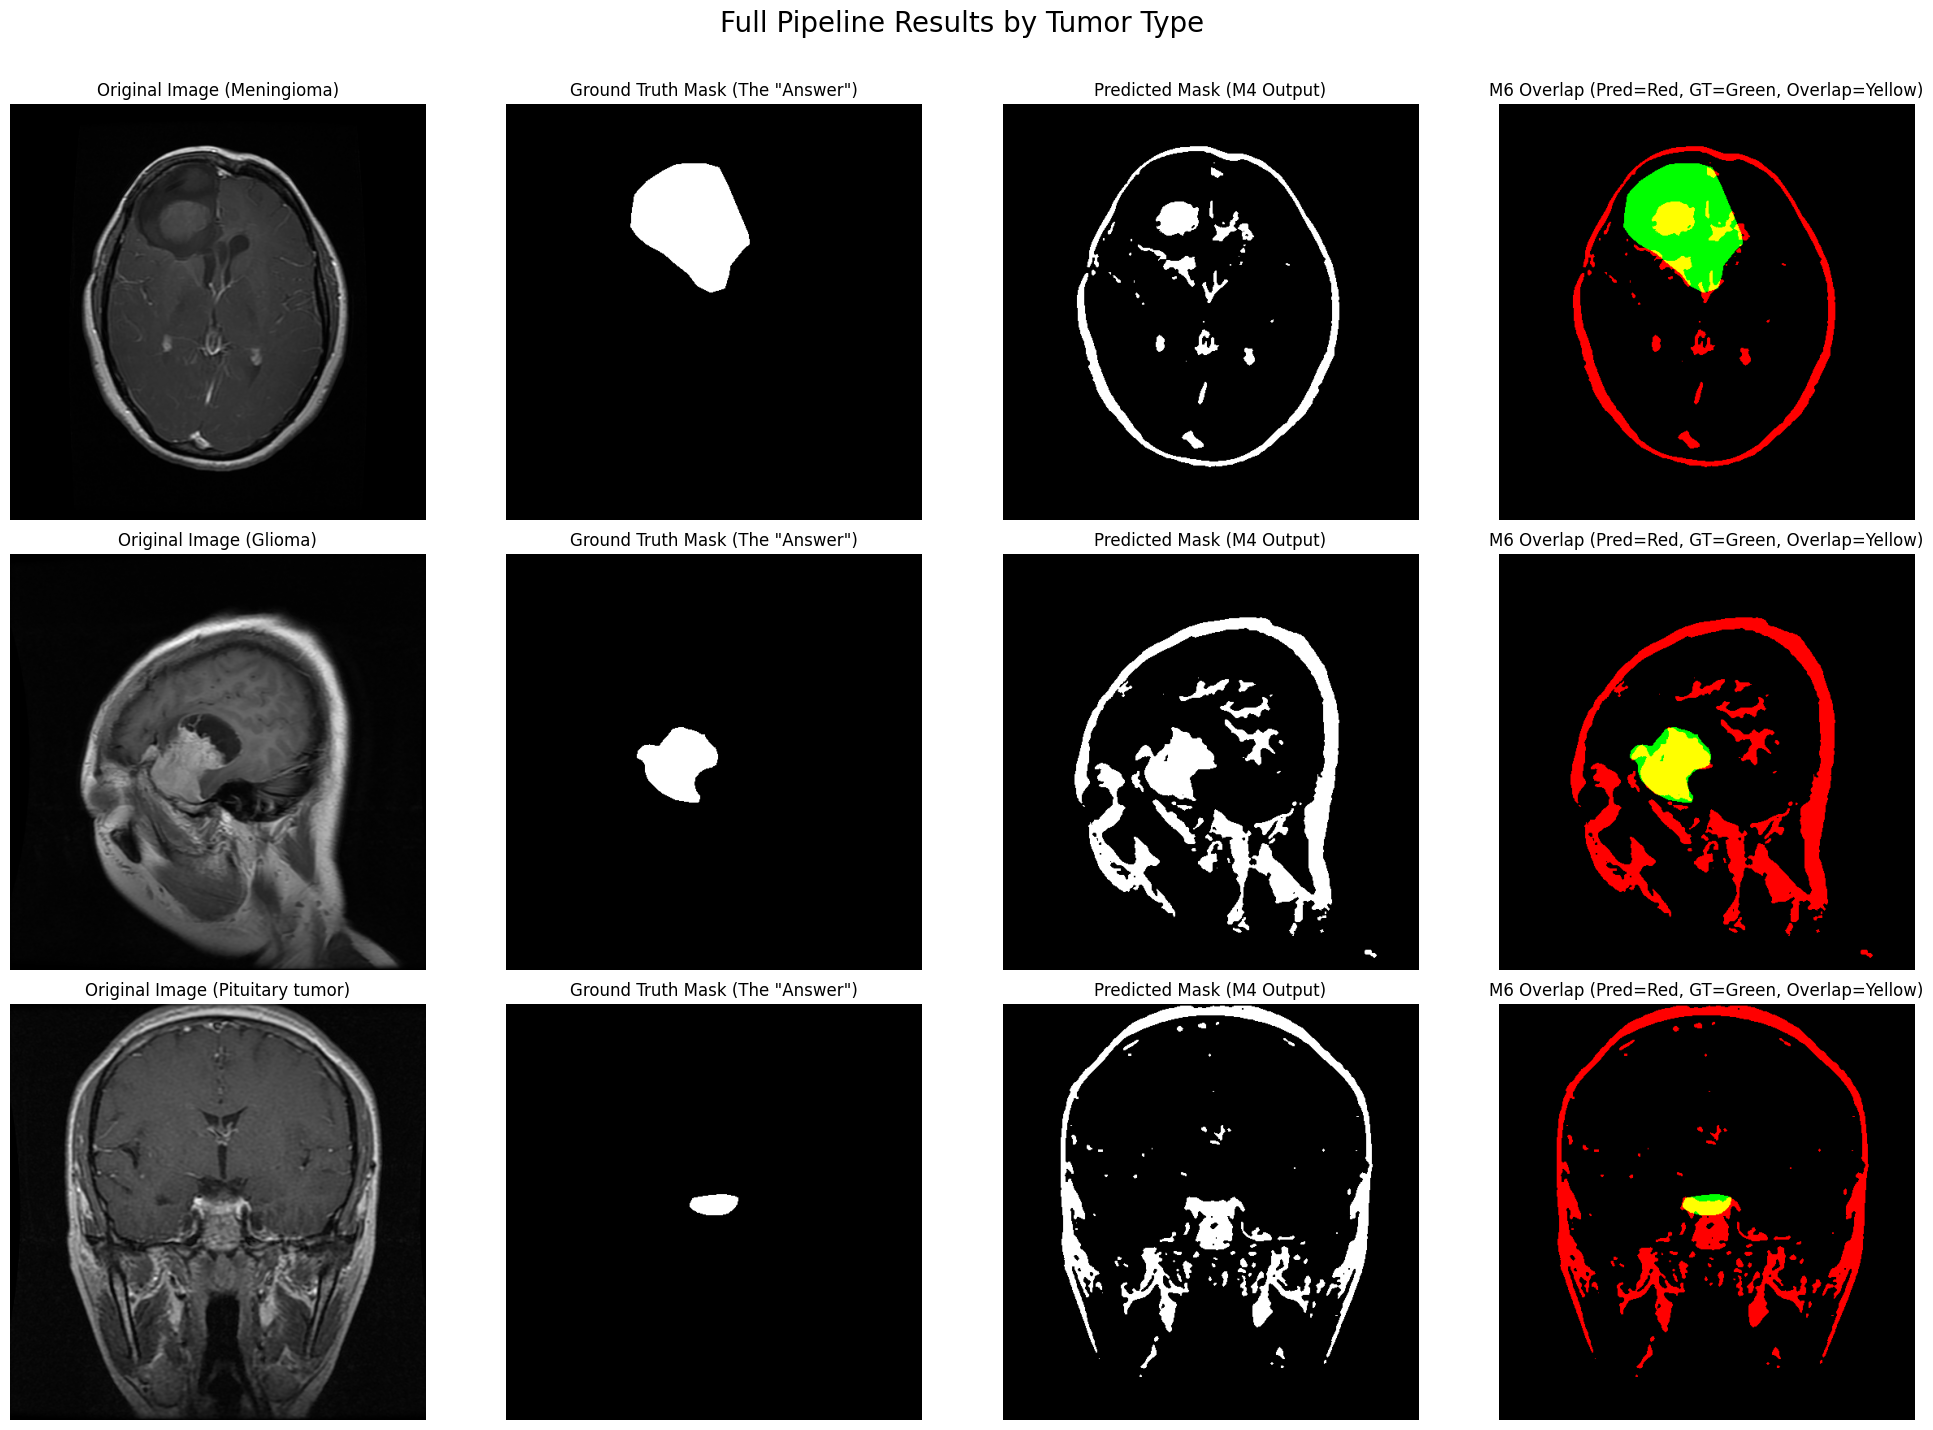

In [8]:
fig, axes = plt.subplots(3, 4, figsize=(20, 15)) # 3 rows (types), 4 columns (images)
fig.suptitle('Full Pipeline Results by Tumor Type', fontsize=20)

for i, tumor_type in enumerate(TUMOR_TYPES):
    example_file = example_files[tumor_type]

    # --- 4. Build Paths ---
    original_img_path = os.path.join(GT_MASK_BASE_DIR, tumor_type, example_file)
    gt_mask_path = os.path.join(GT_MASK_BASE_DIR, tumor_type, example_file.replace('.png', '_mask.png'))
    pred_mask_path = os.path.join(PRED_MASK_BASE_DIR, tumor_type, example_file.replace('.png', '_tumor_mask.png'))

    # --- 5. Load Images ---
    original_img = cv2.imread(original_img_path, 0)
    gt_mask = cv2.imread(gt_mask_path, 0)
    pred_mask = cv2.imread(pred_mask_path, 0)

    # --- 6. Create Overlap Visualization ---
    overlap_vis = np.zeros((original_img.shape[0], original_img.shape[1], 3), dtype=np.uint8)
    if gt_mask is not None and pred_mask is not None:
        # Convert to boolean for logical operations
        gt_bool = gt_mask.astype(bool)
        pred_bool = pred_mask.astype(bool)

        # Legend: Red=Predicted, Green=Ground Truth, Yellow=Overlap
        overlap_vis[np.logical_and(pred_bool, ~gt_bool)] = [255, 0, 0] # Predicted only (Red)
        overlap_vis[np.logical_and(~pred_bool, gt_bool)] = [0, 255, 0] # Ground Truth only (Green)
        overlap_vis[np.logical_and(pred_bool, gt_bool)] = [255, 255, 0] # Overlap (Yellow)

    # --- 7. Plot this row ---

    # Column 1: Original Image
    axes[i, 0].imshow(original_img, cmap='gray')
    axes[i, 0].set_title(f'Original Image ({tumor_type})')
    axes[i, 0].axis('off')

    # Column 2: Ground Truth Mask
    axes[i, 1].imshow(gt_mask, cmap='gray')
    axes[i, 1].set_title('Ground Truth Mask (The "Answer")')
    axes[i, 1].axis('off')

    # Column 3: Predicted Mask
    axes[i, 2].imshow(pred_mask, cmap='gray')
    axes[i, 2].set_title('Predicted Mask (M4 Output)')
    axes[i, 2].axis('off')

    # Column 4: Overlap Visualization
    axes[i, 3].imshow(overlap_vis)
    axes[i, 3].set_title('M6 Overlap (Pred=Red, GT=Green, Overlap=Yellow)')
    axes[i, 3].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout for main title
plt.show()

In [9]:
import shutil

output_zip_file = '/content/drive/MyDrive/M6_Visualization_Output.zip'
shutil.make_archive('/content/drive/MyDrive/M6_Visualization_Output', 'zip', OUTPUT_VISUAL_BASE_DIR)

print(f"Visualization output zipped to: {output_zip_file}")
print("You can find this file in your Google Drive and download it from there.")

Visualization output zipped to: /content/drive/MyDrive/M6_Visualization_Output.zip
You can find this file in your Google Drive and download it from there.
